# Machine Learning Model 이용

이 노트북에서는 실행 중인 서버와 상호 작용하기 위해 Python의 `requests` 라이브러리를 사용하는 최소 클라이언트를 코딩합니다.

In [1]:
import os
import io
import cv2
import requests
import numpy as np
from IPython.display import Image, display

## URL 이해

1. 서버는 URL [http://localhost:8000/](http://localhost:8000/) 에서 호스팅됩니다.
2. 모델을 제공하는 엔드포인트는 `/predict` 엔드포인트입니다.

`yolov3` 또는 `yolov3-tiny` 모델을 지정할 수 있습니다. 계산 효율성을 위해 작은 버전을 사용합니다.

In [2]:
base_url = 'http://localhost:8000'
endpoint = '/predict'
model = 'yolov4-tiny'

모델을 사용하려면 기본 URL에 엔드포인트를 추가하여 전체 URL을 가져옵니다. "?" 문자 다음에 매개변수의 이름과 값이 옵니다.

In [3]:
url_with_endpoint_no_params = base_url + endpoint
full_url = url_with_endpoint_no_params + "?model=" + model
full_url

'http://localhost:8000/predict?model=yolov4-tiny'

이 endpoint에는 모델 이름과 이미지가 모두 필요합니다. 그러나 이미지는 복잡하기 때문에 URL 내에서 전달되지 않고 `requests` 라이브러리를 활용하여 처리 합니다.

# 서버에 요청 보내기

### response_from_server 함수 코딩

request와 함께 파일을 전달하려면 파일 이름(이 경우 'file')과 실제 파일을 나타내는 dictionary를 생성해야 합니다.

 `status code 200`은 모든 것이 잘 진행되었음을 의미합니다.

In [4]:
def response_from_server(url, image_file, verbose=True):
    """서버에 POST 요청을 보내고 응답을 반환합니다.

    Args:
        url: 요청을 보낼 URL.
        image_file: 업로드할 파일, 이미지여야 합니다.
        verbose (bool): 응답 상태를 출력할지 여부를 결정합니다. True일 경우 상태를 출력합니다.

    Returns:
        requests.models.Response: 서버로부터의 응답.
    """
    
    # 파일을 포함한 요청 데이터 구성
    files = {'file': image_file}
    
    # 서버에 POST 요청을 보냅니다.
    response = requests.post(url, files=files)
    
    # 응답 상태 코드를 가져옵니다.
    status_code = response.status_code
    
    # verbose가 True일 경우 상태 메시지를 출력합니다.
    if verbose:
        msg = "성공적으로 처리 되었습니다." if status_code == 200 else "요청을 처리하는 동안 오류가 발생했습니다."
        print(msg)
    
    # 서버로부터의 응답을 반환합니다.
    return response

In [5]:
with open("images/clock2.jpg", "rb") as image_file:
    # 서버에 파일을 POST 요청으로 보내고 예측 결과를 받습니다.
    prediction = response_from_server(full_url, image_file)

성공적으로 처리 되었습니다.


bounding box와 레이블이 있는 이미지를 얻으려면 응답 내용을 적절한 형식으로 parsing 해야 합니다.  
이를 위해 'images_predicted'라는 디렉토리를 만들어 이미지를 저장합니다.

In [6]:
dir_name = "images_predicted"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)  #directory 없으면 생성

### display_image_from_response 함수 작성

In [7]:
def display_image_from_response(response):
    """서버의 응답으로부터 이미지를 표시합니다.

    Args:
        response (requests.models.Response): 객체 탐지 후 서버로부터의 응답.
    """
    
    # 서버 응답의 콘텐츠를 바이트 스트림으로 변환합니다.
    image_stream = io.BytesIO(response.content)
    
    # 스트림의 위치를 처음으로 되돌립니다.
    image_stream.seek(0)
    
    # 바이트 스트림을 numpy 배열로 변환합니다.
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    
    # numpy 배열을 이미지로 디코딩합니다.
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    
    # 이미지를 파일로 저장합니다.
    filename = "image_with_objects.jpeg"
    cv2.imwrite(f'images_predicted/{filename}', image)
    
    # 저장된 이미지를 표시합니다.
    display(Image(f'images_predicted/{filename}'))

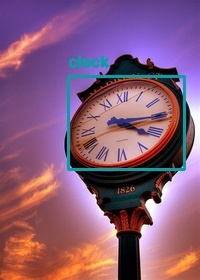

In [8]:
display_image_from_response(prediction)

다른 이미지에서 테스트해 봅니다.

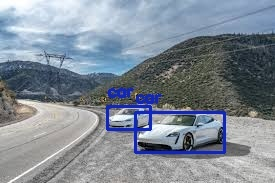

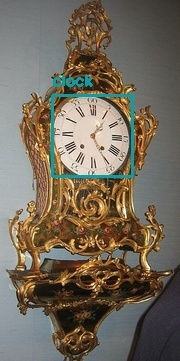

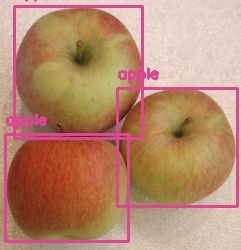

In [9]:
image_files = [
    'car2.jpg',
    'clock3.jpg',
    'apples.jpg'
]

for image_file in image_files:
    with open(f"images/{image_file}", "rb") as image_file:
        prediction = response_from_server(full_url, image_file, verbose=False)
    
    display_image_from_response(prediction)

위의 코드는 실제 프로덕션 환경에서 딥 러닝 모델을 배포하고 모델을 사용하는 프로세스와 비슷합니다.